# Определение перспективного тарифа для телеком-компании

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». 
Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
В данном проекте представлен предварительный анализ тарифов на небольшой выборке клиентов. Выборка содержит данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Цель проекта - анализ поведения клиентов и выбор лучшего тарифа.

## 1. Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st

tariffs = pd.read_csv('tariffs.csv', sep = ',')
users = pd.read_csv('users.csv', sep = ',')
messages = pd.read_csv('messages.csv', sep = ',')
internet = pd.read_csv('internet.csv', sep = ',')
calls = pd.read_csv('calls.csv', sep = ',')
display(tariffs.head(), users.head(), messages.head(), internet.head(), calls.head())
print(tariffs.info(), users.info(), messages.info(), internet.info(), calls.info())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null  

Для начала нужно посмотреть на имеющиеся данные. В данном случае это 5 таблиц, содержащие информацию о пользователях, тарифах, звонках, сообщениях, интернет-трафике. Таблица о тарифах состоит из двух строк и соответственно содержит данные о двух тарифах smart и ultra, в них описаны тарифные условия, пропусков нет, типы данных - int.  В ней ничего менять не нужно.
Таблица о пользователях содержит информацию об id, возрасте, дате прекращения пользования тарифом, городе, дате регистрации, имени и фамилии, и тарифе. В этой таблице пропуски есть только в столбце churn_date, но они там и должны быть, т.к. большая часть пользователей продолжает пользоваться тарифом. В таблице указаны даты, однако формат данных object, потребуется предобработка. 
Таблица про сообщения содержит информацию о каждом отправленном смс, пропусков нет, но дата так же в формате object.
Таблица об интернет трафике содержит информацию о всех сессиях выхода в интернет, она не содержит пропусков, однако там есть столбец, дублирующий индексы, и дата снова в формате object
В таблице со звонками точно такая же проблема с типом даты, судя по значениям, продолжительность звонка указана в минутах и в формате десятичной дроби, это удобнее, чем минуты и секунды.

## 2.  Предобработка данных

### 2.1 Типы данных

In [2]:
# формат даты и времени во всех таблицах одинаковый, напишем функцию
def to_date(col):
    return pd.to_datetime(col, format='%Y-%m-%d')
users['reg_date'] = to_date(users['reg_date'])
users['churn_date'] = to_date(users['churn_date'])
messages['message_date'] = to_date(messages['message_date'])
internet['session_date'] = to_date(internet['session_date'])
calls['call_date'] = to_date(calls['call_date'])
#print(tariffs.info(), users.info(), messages.info(), internet.info(), calls.info())

Теперь все даты переведены в правильный формат. Я проверила это с помощью метода .info(), но его вывод загромождает тетрадь проекта.

### 2.2 Ошибки в данных

In [3]:
# display(users.describe(), internet.describe(), calls.describe()) # данные выглядят хорошо, никаких явных выбросов нет
# осталось только округлить длительность звонков до минут
calls['duration'] = np.ceil(calls['duration'])
internet = internet.query('mb_used != 0 ') #избавимся от нулевых сессий
print(internet)

        Unnamed: 0        id  mb_used session_date  user_id
0                0    1000_0   112.95   2018-11-25     1000
1                1    1000_1  1052.81   2018-09-07     1000
2                2    1000_2  1197.26   2018-06-25     1000
3                3    1000_3   550.27   2018-08-22     1000
4                4    1000_4   302.56   2018-09-24     1000
...            ...       ...      ...          ...      ...
149390      149390  1499_151   752.72   2018-10-11     1499
149391      149391  1499_152   318.90   2018-10-03     1499
149392      149392  1499_153   490.13   2018-12-14     1499
149394      149394  1499_155  1246.32   2018-11-26     1499
149395      149395  1499_156   544.37   2018-10-26     1499

[129798 rows x 5 columns]


### 2.2 Группировка по месяцам

In [4]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month #выделение месяца из даты
calls['month'] = pd.DatetimeIndex(calls['call_date']).month 
internet['month'] = pd.DatetimeIndex(internet['session_date']).month 
messages_gr = pd.pivot_table(messages, index=['user_id', 'month'], values=['message_date'], aggfunc=len).reset_index()
calls_count = pd.pivot_table(calls, index=['user_id', 'month'], values=['call_date'], aggfunc=len).reset_index()
calls_duration = pd.pivot_table(calls, index=['user_id', 'month'], values=['duration'], aggfunc=sum).reset_index()
traffic_gr = pd.pivot_table(internet, index=['user_id', 'month'], values=['mb_used'], aggfunc=sum).reset_index()

# а вот теперь пришло время округлить трафик до мегабайтов
traffic_gr['mb_used'] = np.ceil(traffic_gr['mb_used'])
traffic_gr['mb_used'] = traffic_gr['mb_used'].astype(int)
traffic_gr

,user_id,month,mb_used
0,1000,5,2254
1,1000,6,23234
2,1000,7,14004
3,1000,8,14056
4,1000,9,14569
...,...,...,...
3196,1498,10,20580
3197,1499,9,1846
3198,1499,10,17789
3199,1499,11,17964


### 2.3 Сведение в таблицу

In [5]:
df = messages_gr.merge(calls_count, how='outer', on=['user_id', 'month'])
df = df.merge(calls_duration, how='outer', on=['user_id', 'month'])
df = df.merge(traffic_gr, on=['user_id', 'month'])
df = df.merge(users, on=['user_id'], )
display(df)
display(df.info())

,user_id,month,message_date,call_date,duration,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,22.0,159.0,2254,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,60.0,43.0,172.0,23234,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,75.0,47.0,340.0,14004,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,81.0,52.0,408.0,14056,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,57.0,58.0,466.0,14569,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,1494,8,NaN,32.0,262.0,6591,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart
3196,1494,9,NaN,66.0,501.0,16963,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart
3197,1494,10,NaN,52.0,354.0,17768,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart
3198,1494,11,NaN,63.0,411.0,18053,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3200 entries, 0 to 3199
Data columns (total 13 columns):
user_id         3200 non-null int64
month           3200 non-null int64
message_date    2704 non-null float64
call_date       3161 non-null float64
duration        3161 non-null float64
mb_used         3200 non-null int64
age             3200 non-null int64
churn_date      186 non-null datetime64[ns]
city            3200 non-null object
first_name      3200 non-null object
last_name       3200 non-null object
reg_date        3200 non-null datetime64[ns]
tariff          3200 non-null object
dtypes: datetime64[ns](2), float64(3), int64(4), object(4)
memory usage: 350.0+ KB


None

Соединила поочередно таблицы messages, calls_count, calls_duration, traffic_gr и users. Получилось так, что в столбцах про звонки и смс есть пропуски. Можно заменить их на нули, т.к. в исходных таблицах этих значений не было вообще.

In [6]:
df['message_date'] = df['message_date'].fillna(0)
df['call_date'] = df['call_date'].fillna(0)
df['duration'] = df['duration'].fillna(0)
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3200 entries, 0 to 3199
Data columns (total 13 columns):
user_id         3200 non-null int64
month           3200 non-null int64
message_date    3200 non-null float64
call_date       3200 non-null float64
duration        3200 non-null float64
mb_used         3200 non-null int64
age             3200 non-null int64
churn_date      186 non-null datetime64[ns]
city            3200 non-null object
first_name      3200 non-null object
last_name       3200 non-null object
reg_date        3200 non-null datetime64[ns]
tariff          3200 non-null object
dtypes: datetime64[ns](2), float64(3), int64(4), object(4)
memory usage: 350.0+ KB


None

### 2.4 Помесячная выручка с каждого пользователя

In [7]:
def message_price(row): #стоимость смс
    if row['tariff'] == 'smart':
        if row['message_date'] <= 50:
            return 0
        else:
            return (row['message_date'] - 50) * 3
    else:
        if row['message_date'] <= 1000:
            return 0
        else:
            return (row['message_date'] - 1000)
df['message_price'] = df.apply(message_price, axis=1)
def calls_price(row): #стоимость звонков 
    if row['tariff'] == 'smart':
        if row['duration'] <= 500:
            return 0
        else:
            return (row['duration'] - 50) * 3 
    else:
        if row['duration'] <= 3000:
            return 0
        else:
            return (row['duration'] - 3000)
df['calls_price'] = df.apply(calls_price, axis=1)
def internet_price(row): #стоимость интернета
    if row['tariff'] == 'smart':
        if row['mb_used'] <= 15360:
            return 0
        else:
            return math.ceil((row['mb_used'] - 15360) / 1024) * 200
    else:
        if row['mb_used'] <= 30720:
            return 0
        else:
            return math.ceil((row['mb_used'] - 30720) / 1024) * 150

df['internet_price'] = df.apply(internet_price, axis=1)

def sum_per_month(row): #сумма за месяц
    if row['tariff'] == 'smart':
        return (row['message_price'] + row['calls_price'] + row['internet_price'] + 550)
    else:
        return (row['message_price'] + row['calls_price'] + row['internet_price'] + 1950)
  

df['sum_per_month'] = df.apply(sum_per_month, axis=1)
columns = ['age', 'churn_date', 'first_name', 'last_name', 'reg_date', 'message_price', 'calls_price', 'internet_price']
df.drop(columns, inplace=True, axis=1)  
display(df)

,user_id,month,message_date,call_date,duration,mb_used,city,tariff,sum_per_month
0,1000,5,22.0,22.0,159.0,2254,Краснодар,ultra,1950.0
1,1000,6,60.0,43.0,172.0,23234,Краснодар,ultra,1950.0
2,1000,7,75.0,47.0,340.0,14004,Краснодар,ultra,1950.0
3,1000,8,81.0,52.0,408.0,14056,Краснодар,ultra,1950.0
4,1000,9,57.0,58.0,466.0,14569,Краснодар,ultra,1950.0
...,...,...,...,...,...,...,...,...,...
3195,1494,8,0.0,32.0,262.0,6591,Омск,smart,550.0
3196,1494,9,0.0,66.0,501.0,16963,Омск,smart,2303.0
3197,1494,10,0.0,52.0,354.0,17768,Омск,smart,1150.0
3198,1494,11,0.0,63.0,411.0,18053,Омск,smart,1150.0


Получилась таблица, в которой собраны сообщения, звонки, трафик пользователей за месяц, а также сумма, которую они тратят за месяц на связь

## 3. Анализ данных
Здесь нужно описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Требуется посчитать среднее количество, дисперсию и стандартное отклонение, построить гистограммы, описать распределения.

In [8]:
#логично разделить сводную таблицу на две части по используемому тарифу
smart = df.query('tariff == "smart"')
ultra = df.query('tariff == "ultra"')
display(smart) 
display(ultra)

,user_id,month,message_date,call_date,duration,mb_used,city,tariff,sum_per_month
8,1002,6,4.0,15.0,117.0,10857,Стерлитамак,smart,550.0
9,1002,7,11.0,26.0,214.0,17581,Стерлитамак,smart,1150.0
10,1002,8,13.0,42.0,289.0,20320,Стерлитамак,smart,1550.0
11,1002,9,4.0,36.0,206.0,16692,Стерлитамак,smart,950.0
12,1002,10,10.0,33.0,212.0,13889,Стерлитамак,smart,550.0
...,...,...,...,...,...,...,...,...,...
3195,1494,8,0.0,32.0,262.0,6591,Омск,smart,550.0
3196,1494,9,0.0,66.0,501.0,16963,Омск,smart,2303.0
3197,1494,10,0.0,52.0,354.0,17768,Омск,smart,1150.0
3198,1494,11,0.0,63.0,411.0,18053,Омск,smart,1150.0


,user_id,month,message_date,call_date,duration,mb_used,city,tariff,sum_per_month
0,1000,5,22.0,22.0,159.0,2254,Краснодар,ultra,1950.0
1,1000,6,60.0,43.0,172.0,23234,Краснодар,ultra,1950.0
2,1000,7,75.0,47.0,340.0,14004,Краснодар,ultra,1950.0
3,1000,8,81.0,52.0,408.0,14056,Краснодар,ultra,1950.0
4,1000,9,57.0,58.0,466.0,14569,Краснодар,ultra,1950.0
...,...,...,...,...,...,...,...,...,...
3184,1469,8,0.0,114.0,779.0,33039,Сочи,ultra,2400.0
3185,1469,9,0.0,104.0,763.0,33703,Сочи,ultra,2400.0
3186,1469,10,0.0,123.0,908.0,33384,Сочи,ultra,2400.0
3187,1469,11,0.0,111.0,795.0,35502,Сочи,ultra,2700.0


### 3.1 Сколько минут разговора требуется пользователям каждого тарифа в месяц

count    2227.000000
mean      418.268523
std       190.073088
min         0.000000
25%       282.500000
50%       422.000000
75%       545.000000
max      1435.000000
Name: duration, dtype: float64

самое частое значение (мода) для тарифа Смарт равно 0    437.0
dtype: float64
дисперсия для тарифа Смарт равна 36127.778716729386


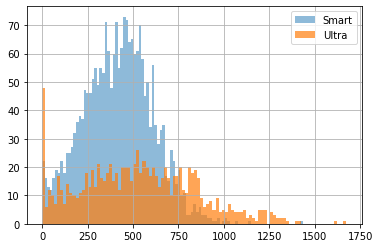

count     973.000000
mean      530.728674
std       317.203175
min         0.000000
25%       295.000000
50%       521.000000
75%       752.000000
max      1673.000000
Name: duration, dtype: float64

самое частое значение (мода) для тарифа Ультра равно 0    0.0
dtype: float64
дисперсия для тарифа Ультра равна 100617.85429011288


In [9]:
smart['duration'].hist(bins=100, alpha=0.5, label = 'Smart') # распределение минут разговора в месяц
display(smart['duration'].describe()) # статистика
print('самое частое значение (мода) для тарифа Смарт равно', smart['duration'].mode()) # мода
print("дисперсия для тарифа Смарт равна", np.var(smart['duration'], ddof=1)) # дисперсия, ddof=1, т.к. мы работаем с выборкой, а не с генеральной совокупностью

#ультра звонки
ultra['duration'].hist(bins=100, alpha=0.7, label = 'Ultra') # распределение минут разговора в месяц
plt.legend()
plt.show()
display(ultra['duration'].describe()) 
print('самое частое значение (мода) для тарифа Ультра равно', ultra['duration'].mode())
print("дисперсия для тарифа Ультра равна", np.var(ultra['duration'], ddof=1))

Для пользователей тарифа Смарт распределение в целом стремится к нормальному. Есть выбросы в области около 1400 минут, потому что некоторые пользователи разговаривают дольше других. Но самое частое значение в выборке как раз находится около лимита в 500 минут: среднее - 418 минут, медиана - 422, мода - 437. Среднее меньше всех, т.к. на него влияет большая плотность значений в районе нуля, гистограмма слегка скошена вправо. Стандартное отклонение - 190, а дисперсия, его квадрат, соответственно 36159.

Среди пользователей тарифа Ультра достаточно много пользователей, которые не разговаривают совсем, мода находится на отметке 0, дисперсия больше, чем у смартов, гистограмма более плоская, об этом говорит и большое среднеквадратичное отклонение - 317, а также его квадрат, 100699. Медиана и среднее равны 520 и 530 соответственно, т.е. достаточно большое число тех, кто выбрал этот тариф, немного не укладывались в лимит смарта 500 минут.

### 3.2 Сколько сообщений требуется пользователям каждого тарифа в месяц

count    2227.000000
mean       33.413112
std        28.223851
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: message_date, dtype: float64

самое частое значение (мода) для тарифа Смарт равна 0    0.0
dtype: float64
дисперсия для тарифа Смарт равна 796.5857758918057


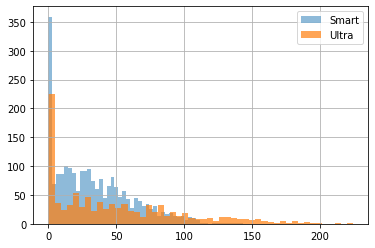

count    973.000000
mean      49.684481
std       47.978006
min        0.000000
25%        6.000000
50%       39.000000
75%       79.000000
max      224.000000
Name: message_date, dtype: float64

самое частое значение (мода) для тарифа Ультра равна 0    0.0
dtype: float64
дисперсия для тарифа Ультра равна 2301.889028459772


In [10]:
smart['message_date'].hist(bins=50, alpha=0.5, label = 'Smart') # распределение количества сообщений в месяц
display(smart['message_date'].describe())
print('самое частое значение (мода) для тарифа Смарт равна', smart['message_date'].mode())
print("дисперсия для тарифа Смарт равна", np.var(smart['message_date'], ddof=1))
# ультра смс
ultra['message_date'].hist(bins=50, alpha=0.7,  label = 'Ultra') # распределение количества сообщений в месяц
plt.legend()
plt.show()
display(ultra['message_date'].describe())
print('самое частое значение (мода) для тарифа Ультра равна', ultra['message_date'].mode())
print("дисперсия для тарифа Ультра равна", np.var(ultra['message_date'], ddof=1))


С сообщениями история неоднозначна. Многие считают их бесполезными с появлением мессенджеров, некоторые продолжают использовать, отсюда и пик в области нуля, там находится мода в обеих выборках. Но в среднем пользователи тарифа смарт отправляют 33 смс в месяц, пополам выборку делит значение в 28 смс. Дисперсия примерно равна 797.
У пользователей тарифа ультра разброс значений шире, хотя, как и пользователи тарифа смарт, они нечасто используют смс, график скошен вправо, медиана меньше среднего (38,5 < 49), дисперсия равна примерно 2302.

### 3.3 Сколько интернета требуется пользователям каждого тарифа в месяц

count     2227.000000
mean     16223.430175
std       5852.970267
min        202.000000
25%      12659.500000
50%      16509.000000
75%      20045.000000
max      38553.000000
Name: mb_used, dtype: float64

среднее значение для тарифа Смарт в Гб равно 15.843193530394029
самое частое значение (мода) для тарифа Смарт равно 0     7024
1    12404
2    13260
3    15522
4    17970
5    18911
dtype: int64
дисперсия для тарифа Смарт равна 34257260.95143407


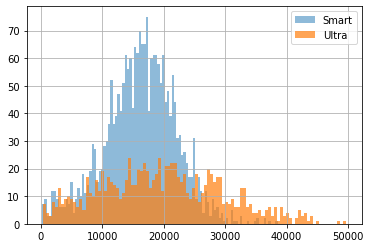

count      973.000000
mean     19708.877698
std       9914.212064
min        366.000000
25%      12100.000000
50%      19424.000000
75%      26928.000000
max      49746.000000
Name: mb_used, dtype: float64

19.24695087679856

среднее значение для тарифа Ультра в Гб равно None
самое частое значение (мода) для тарифа Ультра равно 0      1445
1     10122
2     10929
3     13433
4     15615
5     16090
6     20479
7     22269
8     22819
9     23526
10    25105
11    25209
12    29290
dtype: int64
дисперсия для тарифа Ультра равна 98291600.84613791


In [11]:
smart['mb_used'].hist(bins=100, alpha=0.5, label = 'Smart') # распределение использованных мегабайт в месяц
display(smart['mb_used'].describe())
print("среднее значение для тарифа Смарт в Гб равно", (smart['mb_used'].mean() / 1024))
print("самое частое значение (мода) для тарифа Смарт равно", smart['mb_used'].mode())
print("дисперсия для тарифа Смарт равна", np.var(smart['mb_used'], ddof=1))

ultra['mb_used'].hist(bins=100, alpha=0.7, label = 'Ultra') # распределение использованных мегабайт в месяц
plt.legend()
plt.show()
display(ultra['mb_used'].describe())
print('среднее значение для тарифа Ультра в Гб равно', display(ultra['mb_used'].mean() / 1024))
print('самое частое значение (мода) для тарифа Ультра равно', ultra['mb_used'].mode())
print("дисперсия для тарифа Ультра равна",np.var(ultra['mb_used'], ddof=1))

В среднем, пользователи тарифа смарт нуждаются в 16 гигабайтах трафика в месяц, это немного превышает их лимит в 15 Гб. Форма гистограммы достаточно близка к гистограмме нормального распределения, пик находится примерно на 16 Гб, медиана и среднее находятся очень близко: 16 224 Мб и 16 517 Мб соответственно. Дисперсия равна 34 385 953

Среди пользователей тарифа "ультра" разброс потраченных мегабайт трафика больше. Среднеквадратичное отклонение здесь составляет 9929 мегабайт, дисперсия составляет 98 604 715, среднее примерно равно 19 690, а медиана находится на отметке 19412. Мод в этой выборке гораздо больше, чем среди "смартов", они разбросаны от 1445 мб до 27435 мб, если увеличить число корзин в гистограмме до нескольких тысяч, их можно будет увидеть. 
Пользователи тарифа Ультра гораздо более неоднородная группа, чем пользователи тарифа Смарт, их средние затраты на связь разбросаны в более широких пределах, кроме того, их выборка меньше.

## 4. Проверка гипотез


Нулевая гипотеза:
средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковая
Альтернативная гипотеза:
средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Нулевая гипотеза:
средняя выручка пользователей из Москвы такая же как в других регионах
Альтернативная гипотеза:
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Учитывая, что нужно сравнить средние двух выборок и определить вероятность равенства средних двух генеральных совокупностей, из которых взяты эти выборки, подойдёт метод scipy.stats.ttest_ind (array1, array2,equal_var).
Параметр equal_var в случае первой гипотезы можно заменить на False, т.к. дисперсия пользователей смарта заметно больше дисперсии пользователей тарифа ультра(1186 ^ 2 против 378 ^ 2), при сравнении пользователей из Москвы и из регионов дисперсия отличается не сильно.

count    2227.000000
mean     1747.710373
std      1186.353118
min       550.000000
25%       550.000000
50%      1550.000000
75%      2526.500000
max      8120.000000
Name: sum_per_month, dtype: float64

count     973.000000
mean     2071.634121
std       378.263715
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: sum_per_month, dtype: float64

суммарная выручка от пользователей тарифа смарт за период анализа =  3892151.0
суммарная выручка от пользователей тарифа ультра за период анализа =  2015700.0


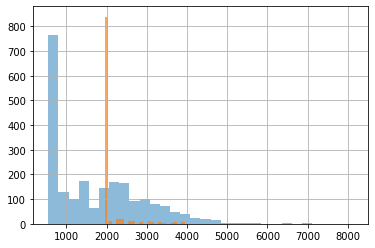

In [12]:
# считаем среднюю выручку с каждого из тарифов
display(smart['sum_per_month'].describe())
display(ultra['sum_per_month'].describe())
print('суммарная выручка от пользователей тарифа смарт за период анализа = ', sum(smart['sum_per_month']))
print('суммарная выручка от пользователей тарифа ультра за период анализа = ', sum(ultra['sum_per_month']))
smart['sum_per_month'].hist(bins=30, alpha=0.5) # распределение затрат на связь в месяц
ultra['sum_per_month'].hist(bins=30, alpha=0.7) 
plt.show()


In [13]:
sample_1 = smart['sum_per_month']
sample_2 = ultra['sum_per_month']
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.7071794478215788e-30
Отвергаем нулевую гипотезу


p оказался значительно меньше значения 0,05, это говорит о том, что разница между средними двух выборок статистически значима, а значит, говорить о равенстве средних двух выборок нельзя. Пользователи тарифа Ультра в среднем тратят на связь больше, чем пользователи тарифа Смарт. Такое же результат получается, даже если не применять параметр equal_var = False.

In [14]:
# теперь пришло время сравнить Москву и регионы
# сначала нужно подготовить выборки к анализу
Moscow_users = df.query('city == "Москва"')
Other_users = df.query('city != "Москва"')

sample_1 = Moscow_users['sum_per_month']
sample_2 = Other_users['sum_per_month']

alpha = .1# критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

display(Moscow_users['sum_per_month'].describe())
display(Other_users['sum_per_month'].describe())

p-значение:  0.5278607479424164
Не получилось отвергнуть нулевую гипотезу


count     610.000000
mean     1822.691803
std       947.083887
min       550.000000
25%       950.000000
50%      1950.000000
75%      2174.250000
max      6671.000000
Name: sum_per_month, dtype: float64

count    2590.000000
mean     1851.740927
std      1039.283492
min       550.000000
25%       950.000000
50%      1950.000000
75%      2314.750000
max      8120.000000
Name: sum_per_month, dtype: float64

Значение p оказалось больше, чем 0,05 и даже больше, чем 0,1, а это значит что средние обеих выборок примерно равны, и скорее всего равны и средние генеральных совокупностей. В регионах на связь тратят примерно столько же, сколько в Москве.

## Вывод

Пользователи операторов мобильной связи очень разные, некоторые не пользуются звонками вообще, некоторые давно не отправляют смс. Действительно, мессенджеры заменили и то, и другое. Из всех, кто приобретал тарифы Смарт и Ультра, интернет-трафик использовали все. Несмотря на более стройные гистограммы средних затрат на звонки, смс и интернет, пользователи тарифа Смарт оказались более разнородными по прибыли, которую они приносят компании. Кто-то четко укладывается в лимиты по звонкам и смс, кто-то тратит гораздо больше и платит сверх абонентской платы. У пользователей тарифа Ультра выходов за пределы лимита меньше, но за счет изначально высокой абонентской платы, они приносят компании больше выручки. Как выяснилось с помощью t-теста, статистически значимо. Его имеет смысл продвигать с помощью рекламы, а тариф Смарт и так популярен, скорее всего за счёт своей низкой стомости. 
Однако однозначно ничего утверждать нельзя, т.к. суммарно за период анализа тариф Смарт принес компании большую сумму за счет большого количества подключенных пользователей. 
Попытка выделить среди пользователей тарифов москвичей оказалась неудачной, средние затраты на связь почти не отличаются, а имеющаяся разница статистически не значима. 